In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from typing import Any
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [114]:
# loading and cleaning data for the model
df = pd.read_csv("cleaned_data.csv",delimiter=";")
df = df.dropna(subset=['price'])
df = df.drop('id', axis=1)
df[['outdoor', 'parking', 'status', 'district']] = df[['outdoor', 'parking', 'status', 'district']].astype('category')

In [115]:
def calculate_regression_metrics(
    y_true: pd.Series, y_pred: np.ndarray
) -> dict[str, Any]:
    """ 
    Calculate regression metrics for model evaluation.
    
    :param y_true: Actual values as a Pandas Series.
    :param y_pred: Predicted values as a 1D numpy array
    
    Metrics:
    - Root Mean Squared Error (RMSE)
    - Mean Absolute Error (MAE)
    - Mean Absolute Percentage Error (MAPE)
    
    :return: A dictionary containing the calculated metrics {"RMSE": rmse, "MAE": mae, "MAPE": mape}.
    """

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape}


def evaluate_regression_model(
    model, X: pd.DataFrame, y: pd.Series, prefix: str
) -> dict[str, float]:
    """
    Evaluate the performance of a regression model on given data.
    
    :param model: The regression model to be evaluated.
    :param X: Feature data as a Pandas DataFrame used for making predictions.
    :param y: Actual target values as a Pandas Series.
    :param prefix: A string prefix to prepend to each metric name in the output dictionary.
    
    Example of output:
    {"train_RMSE": value, "train_MAE": value, "train_MAPE": value}
    or:
    {"test_RMSE": value, "test_MAE": value, "test_MAPE": value}
    
    :return: A dictionary of prefixed metric names with their calculated values.
    """
    y_pred = model.predict(X)
    metrics = calculate_regression_metrics(y, y_pred)
    return {f"{prefix}_{key}": value for key, value in metrics.items()}


def evaluate_model(
    model,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series
) -> dict[str, float]:
    '''
    Evaluate a regression model's performance on training and testing data sets.
    
    :return: A dictionary of metrics with keys as dataset_METRIC
    '''
    train_metrics = evaluate_regression_model(model, X_train, y_train, "train")
    test_metrics = evaluate_regression_model(model, X_test, y_test, "test")

    train_metrics.update(test_metrics)
    return train_metrics


def get_xgb_feature_importances(
    xgb_model, input_features: pd.DataFrame
) -> pd.DataFrame:
    '''
    Extract feature importances from a XGBoost model.

    :param xgb_model: trained XGBoost model
    :param input_features: DataFrame with input features

    :return: DataFrame with feature names and their corresponding importances, 
             sorted by importance in descending order.
    '''
    if not hasattr(xgb_model, "feature_importances_"):
        raise ValueError(
            "The XGBoost model must be fitted before extracting feature importances."
        )

    feature_importances = xgb_model.feature_importances_
    transformed_feature_names = input_features.columns
    feature_importance_dict = dict(zip(transformed_feature_names, feature_importances))

    return pd.DataFrame(
        feature_importance_dict.items(),
        columns=["Feature", "Importance"],
    ).sort_values("Importance", ascending=False)
 

In [ ]:
# creating model for regression
xgboost_model = XGBRegressor(enable_categorical=True)  

In [116]:
X = df.drop('price', axis=1)  # Features
y = df['price']               # Target variable

# split the data into training (80%) and testing sets (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
# training the model on a training data
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [118]:
pickle_filename = "xgboost_model.pkl"
with open(pickle_filename, 'wb') as file:
    pickle.dump(xgboost_model, file)

In [119]:
metrics = evaluate_model(
    xgboost_model,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

In [120]:
metrics

{'train_RMSE': 104830.83249027796,
 'train_MAE': 65470.61283728266,
 'train_MAPE': 7.738295816178839,
 'test_RMSE': 729020.0064292594,
 'test_MAE': 164596.83658329802,
 'test_MAPE': 10.370700278223712}

In [121]:
importances = get_xgb_feature_importances(xgboost_model, X_train)
importances

,Feature,Importance
1,rooms,0.431691
0,area,0.291887
9,max_floor,0.180981
8,district,0.045874
6,build_year,0.017012
7,status,0.009341
4,outdoor,0.008867
2,floor,0.006902
3,rent,0.004892
5,parking,0.002553


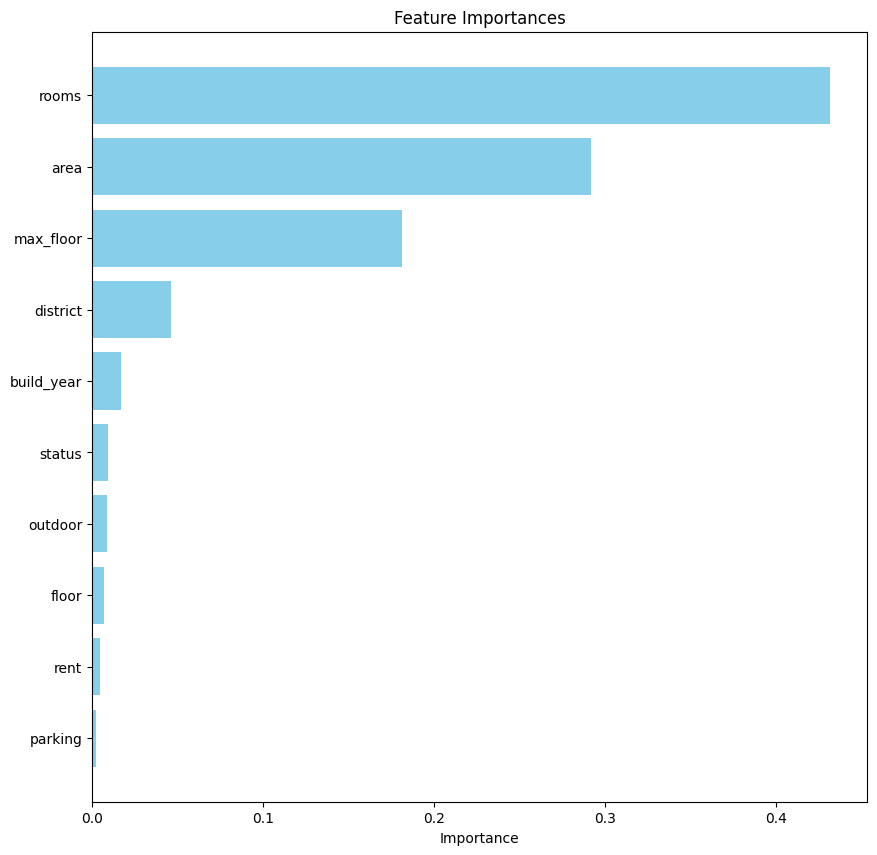

In [112]:
# making a dataframe from feature importances
importances_df = pd.DataFrame(importances, columns=['Index', 'Feature', 'Importance'])
importances_df = importances_df.sort_values(by='Importance', ascending=True)

# creating plot
plt.figure(figsize=(10, 10))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()